In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import open_clip
import random
import os
from sklearn.metrics.pairwise import cosine_similarity

G:\anaconda3\envs\ModeEval\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the BiomedCLIP model and preprocess functions
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Load tokenizer 
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

In [3]:
# Load data
test_caption_file = "../Datasets/ROCO2/test_captions.csv"
test_image_folder = "../Datasets/ROCO2/test_images/test/"
test_df = pd.read_csv(test_caption_file, sep=',', header=1, names=['ID', 'Caption'])
test_df['Image'] = test_df['ID'] + ".jpg"
test_df.drop('ID', axis=1, inplace=True)

# Sample 10 random indices
num_samples = 10
random_indices = random.sample(range(len(test_df)), num_samples)
test_df_subset = test_df.iloc[random_indices].reset_index(drop=True)
test_df_subset

,Caption,Image
0,CT scan showed a large stone causing gastric-o...,ROCOv2_2023_test_000357.jpg
1,CT scan with axial view showing a heterogenous...,ROCOv2_2023_test_009531.jpg
2,Non-contrast computed tomography of the head w...,ROCOv2_2023_test_008028.jpg
3,Computerized tomography scan of the abdomen an...,ROCOv2_2023_test_007965.jpg
4,Inferior facial angle (IFA) measurement.,ROCOv2_2023_test_009484.jpg
5,Imaging findings from whole body PET CT. On fu...,ROCOv2_2023_test_000558.jpg
6,"From a parasternal short-axis view, the transt...",ROCOv2_2023_test_003880.jpg
7,(Case 1) Contrast-enhanced computed tomography...,ROCOv2_2023_test_000337.jpg
8,V Flow ultrasound image of a canine femoral ar...,ROCOv2_2023_test_008248.jpg
9,Contrast-enhanced 3D MR angiography. Forty-yea...,ROCOv2_2023_test_006850.jpg


In [4]:
context_length = 256
# Load and preprocess images
images = torch.stack([preprocess_val(Image.open(test_image_folder + img)) for img in test_df_subset['Image']]).to(device)

# Tokenize captions
captions = tokenizer([caption for caption in test_df_subset['Caption']], context_length=context_length).to(device)

In [5]:
with torch.no_grad():
    image_features, caption_features, logits= model(images, captions)


G:\anaconda3\envs\ModeEval\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


In [6]:
print("Image features shape:", image_features.shape)
print("Caption features shape:", caption_features.shape)

Image features shape: torch.Size([10, 512])
Caption features shape: torch.Size([10, 512])


In [7]:
# Move tensors to CPU and convert to numpy arrays
image_features_np = image_features.cpu().numpy()
caption_features_np = caption_features.cpu().numpy()

# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(image_features_np, caption_features_np)

# Prepare labels
image_labels = test_df_subset['Image'].tolist()
caption_labels = test_df_subset['Caption'].tolist()

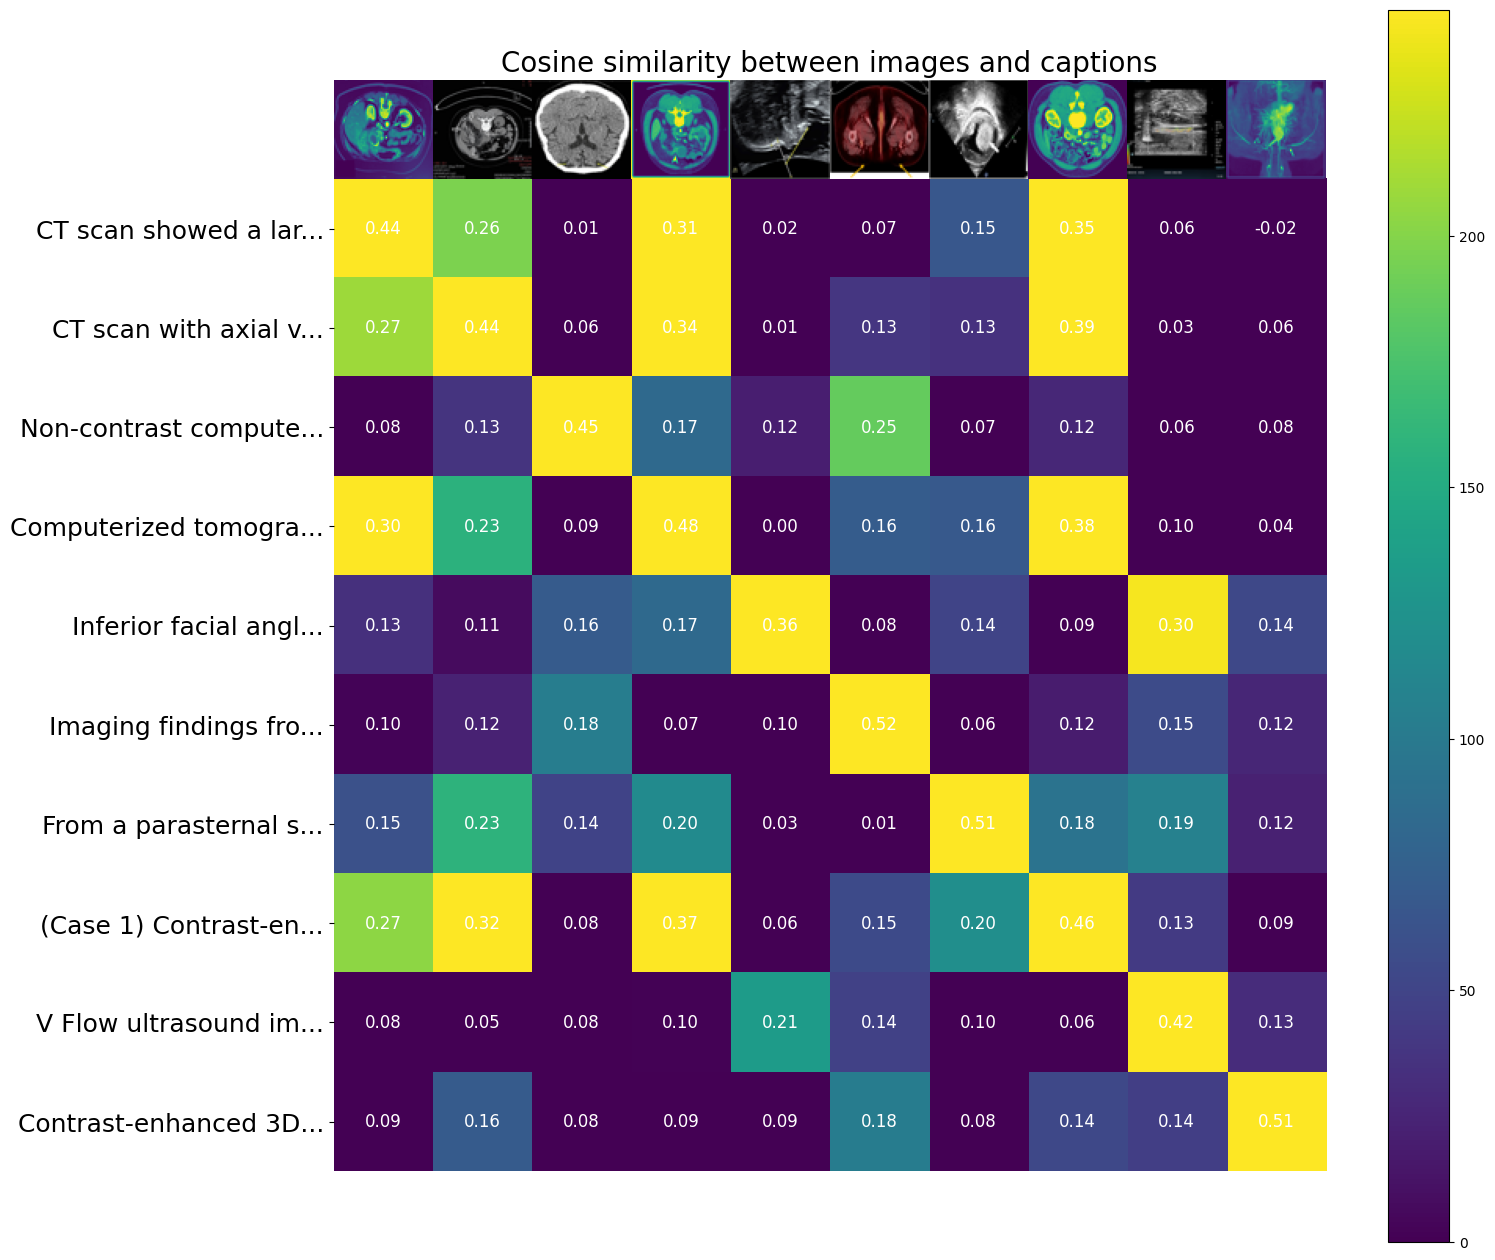

In [8]:
def load_images_from_folder(folder_path, image_labels, size=(64, 64)):
    images = []
    for label in image_labels:
        img_path = os.path.join(folder_path, label)
        if os.path.exists(img_path):
            img = Image.open(img_path).resize(size)  # Resize image for better display
            images.append(img)
    return images

def shorten_labels(labels, max_length=20):
    return [label if len(label) <= max_length else label[:max_length] + '...' for label in labels]

def plot_heatmap(cosine_sim_matrix, image_labels, caption_labels, image_folder, title="Cosine similarity between images and captions"):
    # Shorten captions
    shortened_captions = shorten_labels(caption_labels)

    # Load images
    images = load_images_from_folder(image_folder, image_labels, size=(64, 64))

    count = len(shortened_captions)
    
    plt.figure(figsize=(16, 16))  # Adjust figsize to ensure each cell is large enough
    plt.imshow(cosine_sim_matrix, cmap='viridis', vmin=0.1, vmax=0.3)
    
    # Display images at the bottom
    for i, img in enumerate(images):
        plt.imshow(img, extent=(i - 0.5, i + 0.5, -0.5, -1.5), origin="lower")  # Adjust extent to position images properly
    
    # Display text annotations
    for x in range(cosine_sim_matrix.shape[1]):
        for y in range(cosine_sim_matrix.shape[0]):
            plt.text(x, y, f"{cosine_sim_matrix[y, x]:.2f}", ha="center", va="center", size=12, color='white')
    
    # Customize axes
    plt.yticks(range(count), shortened_captions, fontsize=18)
    plt.xticks([])
    
    # Hide spines
    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)
    
    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count - 0.5, -1.5])  # Adjust limits to fit the images and text
    
    plt.title(title, size=20)
    plt.colorbar()  # Optional: Display colorbar if needed

    plt.show()


plot_heatmap(cosine_sim_matrix, image_labels, caption_labels, test_image_folder)